# Intelligent Data Analysis & Machine Learning I - SS 2025: Final Project

### Mattia D'Agostini 
dagostini@uni-potsdam.de

## Project 1 : Income

Input: tabular data (categorical and numerical columns). Data represents sociological and demographics info of subjects. The target value is the yearly income. The target value is binary and the goal is predicting whether a subject earns more than $50k per year.

<b> Import required packages

In [3]:
#Imports for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

<b> Load CSV

In [4]:
# Load CSV
from db_utils import columns,data_path
df=pd.read_csv(data_path,names=columns)

#Remove initial spaces in string entries
df = df.map(lambda x: x.lstrip() if isinstance(x, str) else x)

#Drop duplicates
df = df.drop_duplicates()

#Drop all columns with unknown salary
df=df[df['income']!="?"]

<b> Missing Values

Let's check how many missing values are in the dataset and their distribution

In [21]:
#Total missing values in df
missing_counts_total = int((df == '?').sum().sum())
print(f"In the dataset there are {missing_counts_total} missing values")

In the dataset there are 759 missing values


In [22]:
#Missing values per column
missing_counts_col = (df == '?').sum()
print(missing_counts_col)

age                      0
employment_type        331
fwf                      0
education_level          0
schooling_period         0
marital_status           0
employment_area        331
partnership              0
ethnicity                0
gender                   0
financial_gains          0
financial_losses         0
weekly_working_time      0
country_of_birth        97
income                   0
dtype: int64


Let's check how many of the employment_type missing values are also employment_area missing values

In [23]:
both_missing = ((df['employment_type'] == '?') & (df['employment_area'] == '?')).sum()
print(f"Rows with both employment_type and employment_area missing: {both_missing}")

Rows with both employment_type and employment_area missing: 331


Let's check how it intercepts with the country_of_birth column

In [24]:
both_missing = ((df['employment_type'] == '?') & (df['country_of_birth'] == '?')).sum()
print(f"Rows with both employment_type and employment_area missing: {both_missing}")

Rows with both employment_type and employment_area missing: 8


This means that, for every subject whose employment is not known, the remaining data is mostly known. We will not remove the unknown values, and since all of the involved columns are categorical, they will be encoded as unknown without problems.

<b> Data Visualization

In [8]:
#Visualize dataset head
df.head()

,age,employment_type,fwf,education_level,schooling_period,marital_status,employment_area,partnership,ethnicity,gender,financial_gains,financial_losses,weekly_working_time,country_of_birth,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We have 2 kinds of columns: numerical and categorical 

<b> Categorical columns </b>: Employment Type, Employment Area, Education Level, Marital Status, Partnership, Ethnicity, Gender, Country of Birth

In [25]:
categorical_cols = ['employment_type','employment_area','education_level','marital_status','partnership','ethnicity','country_of_birth','gender']

Let's visualize the income distribution in categorical columns

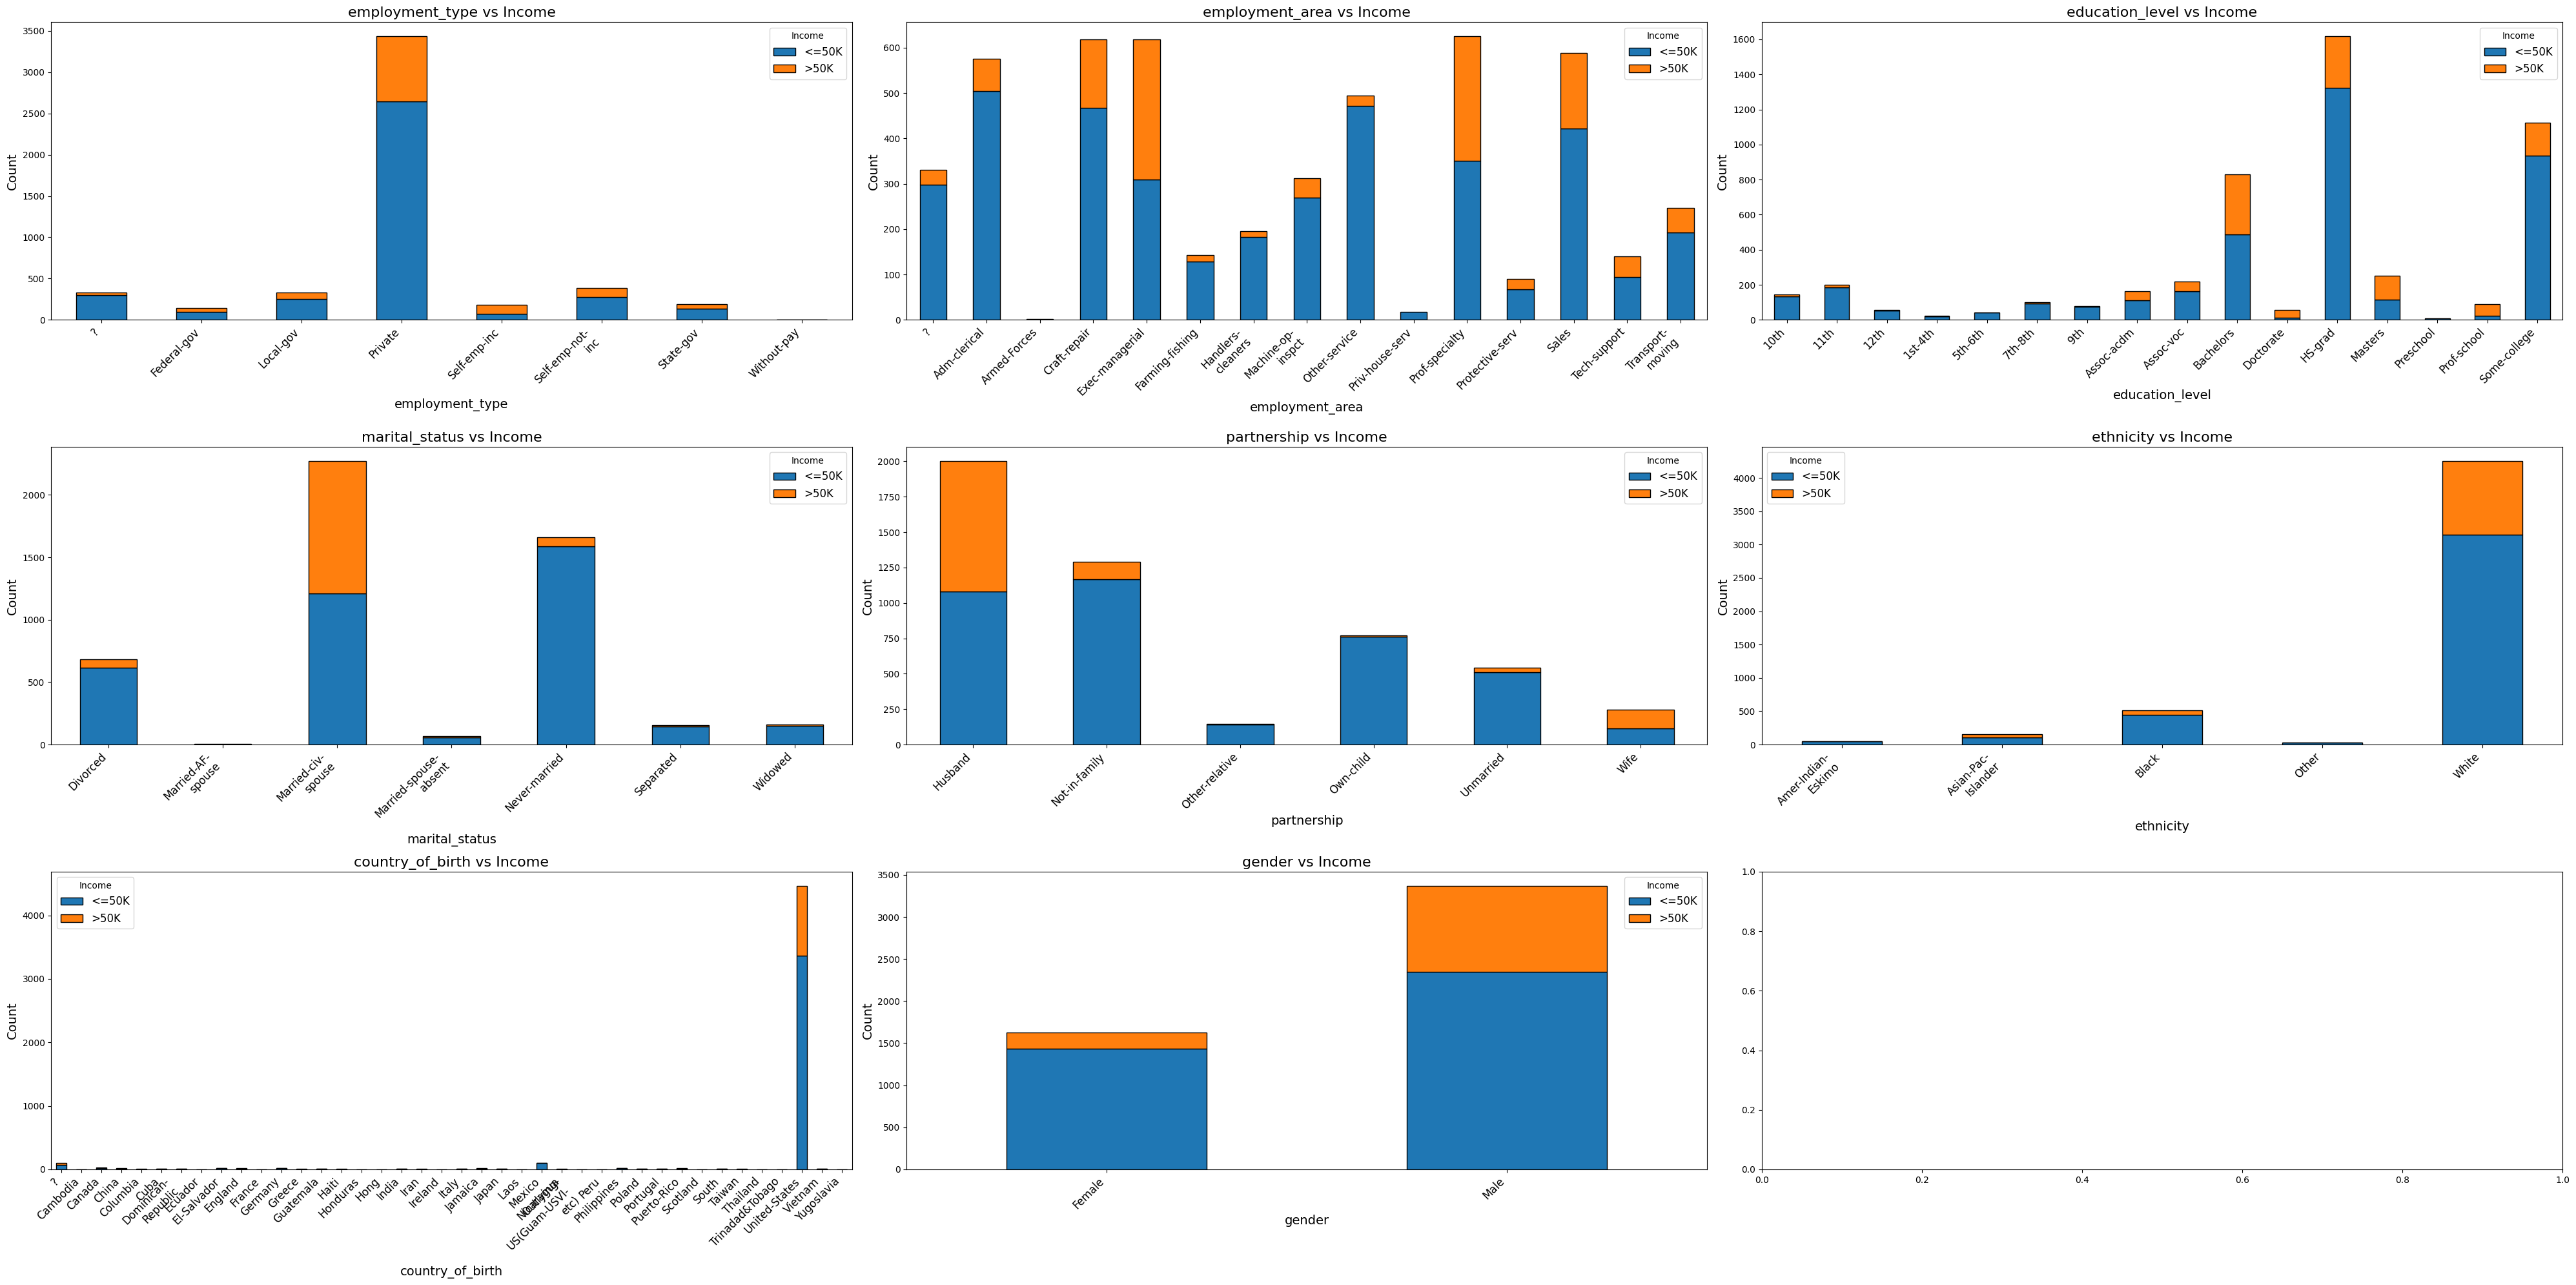

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(40, 20))

for i, col in enumerate(categorical_cols[:9]):
    ax = axes[i // 3, i % 3]
    ct = pd.crosstab(df[col], df["income"])
    ct.plot(kind="bar", stacked=True, ax=ax, edgecolor="black")
    
    ax.set_title(f"{col} vs Income", fontsize=16)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.legend(title="Income", fontsize=12)
    
    # Rotate x-axis labels and wrap long names
    new_labels = [textwrap.fill(str(label), 15) for label in ct.index]
    ax.set_xticklabels(new_labels, rotation=45, ha='right', fontsize=12)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()



<b> Numerical Columns </b> : Age, Weighting Factor, Schooling Period, Financial Gains, Financial Losses, Weekly Working Time

In [26]:
numerical_cols = ['age','fwf','schooling_period','financial_gains','financial_losses','weekly_working_time']

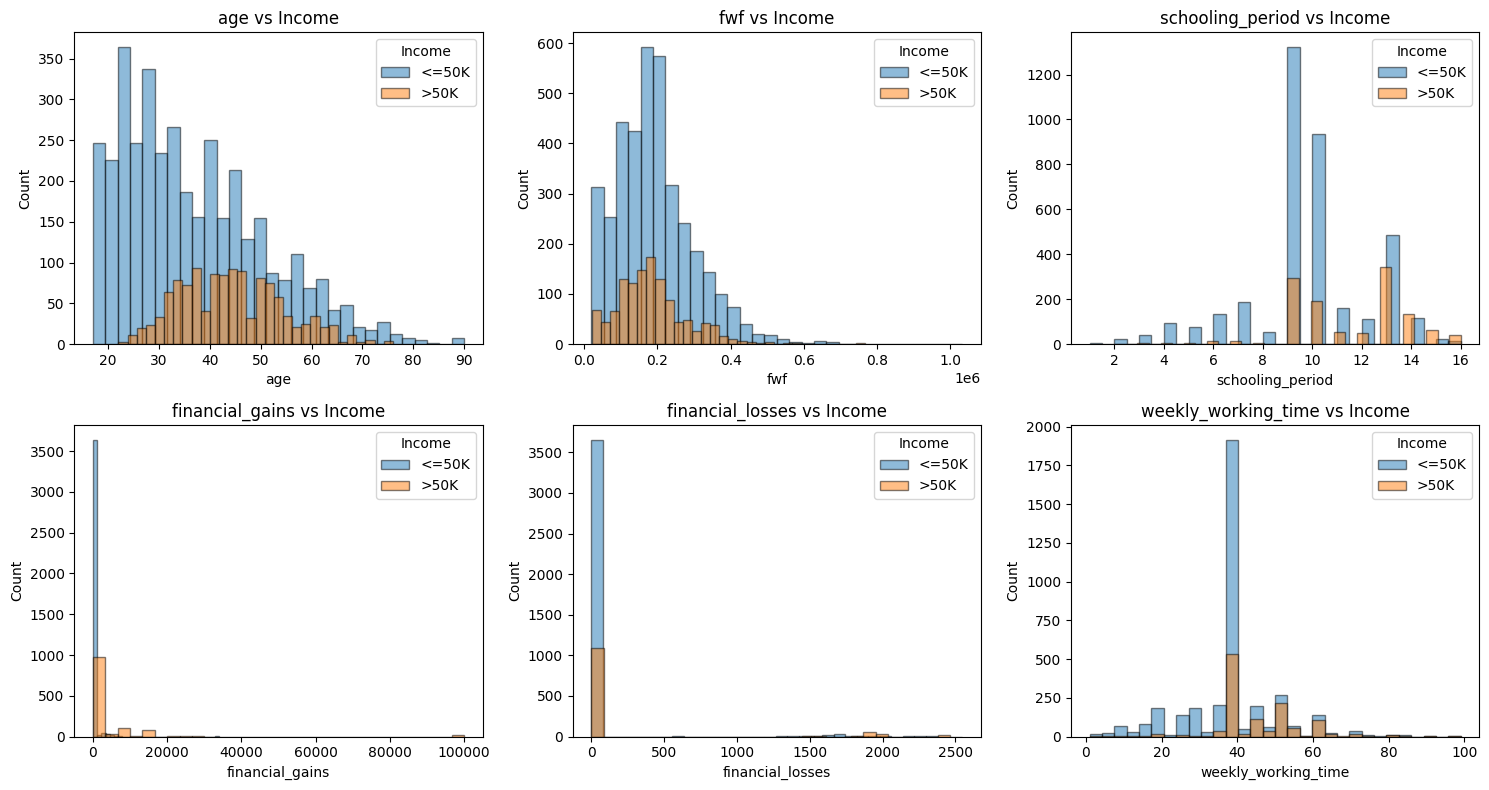

In [27]:
fig, axes = plt.subplots(2,3,figsize=(15, 8))
for i, col in enumerate(numerical_cols[:6]):
    ax = axes[i // 3, i % 3]
    for label, subset in df.groupby("income"):
        ax.hist(subset[col], bins=30, alpha=0.5, label=str(label), edgecolor="black")
    ax.set_title(f"{col} vs Income")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.legend(title="Income")

plt.tight_layout()

<b> Columns To delete and preprocessing

1) Education Level and Schooling Period carry the same meaning and values (just one is categorical and the other one numeric). We can drop the second one and keep the categorical one to avoid redundancy.

In [27]:
df = df.drop(columns=['schooling_period'])
numerical_cols.remove('schooling_period')

<b> Columns Mapping

1) The partnership column can be mapped into married and not married values as data shows that values that fall into the "non-married" map value have a similar trend in terms of income. This reduces dimensionality and helps avoiding overfitting.

In [29]:
#Map defining
married_map = {
    'Husband': 'Married',
    'Wife': 'Married',
    'Not-in-family': 'Not married',
    'Own-child': 'Not married',
    'Unmarried': 'Not married',
    'Other-relative': 'Not married'
}
df['partnership'] = df['partnership'].map(married_map)

Check size for categorical one-hot encoding

In [30]:
total_cat = 0
for column in categorical_cols:
    print (f"Column {column} has {len(df[column].unique())} unique values")
    total_cat += len(df[column].unique())

print(f"With one-hot encoding, features will have a partial size of {total_cat}")

Column employment_type has 8 unique values
Column employment_area has 15 unique values
Column education_level has 16 unique values
Column marital_status has 7 unique values
Column partnership has 2 unique values
Column ethnicity has 5 unique values
Column country_of_birth has 40 unique values
Column gender has 2 unique values
With one-hot encoding, features will have a partial size of 95


We're planning on scaling (using a standard scaler) the remaining, which will have size 1 for each feature

In [31]:
total_num = len(numerical_cols)
print (f"With this preprocessig, features will have a size of {total_cat+total_num} ")
print (f"With this preprocessing, dataset will have a size of {(df.shape[0],total_num+total_cat)}")

With this preprocessig, features will have a size of 100 
With this preprocessing, dataset will have a size of (4999, 100)


The size looks fine, we will proceed with preprocessing as described

First let's remove the income column and use it as target. We will also map y values into 0 and 1

In [ ]:
y = df['income']
X = df.drop(columns=['income'])
y = y.map({'<=50K': 0, '>50K': 1}).astype(int)

In [33]:
#One hot encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

Before scaling we need to split into test and training set, in order to avoid data leakage

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

Now we can scale using a standard scaler (mean: 0 and std:1)

In [35]:
#Scaling
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

X_train[numerical_cols] = std.fit_transform(X_train[numerical_cols]) 
X_test[numerical_cols] = std.transform(X_test[numerical_cols])

### Training Models

We can now train some models and evaluate the model performance on it

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [37]:
models = {
    "Random Forest": RandomForestClassifier(random_state=123),
    "Logistic Regression": LogisticRegression(random_state=123),
    "Decision Tree": DecisionTreeClassifier(random_state=123),
    "SVM": SVC(probability=True, random_state=123)
}

In [38]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,roc_curve

In [39]:
pre_training_results = pd.DataFrame(columns=["Accuracy", "F1", "AUC"], index=models.keys())

for model_name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, y_proba)
    pre_training_results.loc[model_name] = [acc, f1, auc]

Let's sort results by AUC and compare models

In [40]:
pre_training_results = pre_training_results.sort_values(by='AUC',ascending=False)
pre_training_results

,Accuracy,F1,AUC
Logistic Regression,0.838,0.608696,0.900138
Random Forest,0.836,0.62037,0.898484
SVM,0.856,0.64,0.895493
Decision Tree,0.81,0.595745,0.74949


As we can see Logistic Regression is the best model in terms of AUC. Let's plot the AUC curve for these models

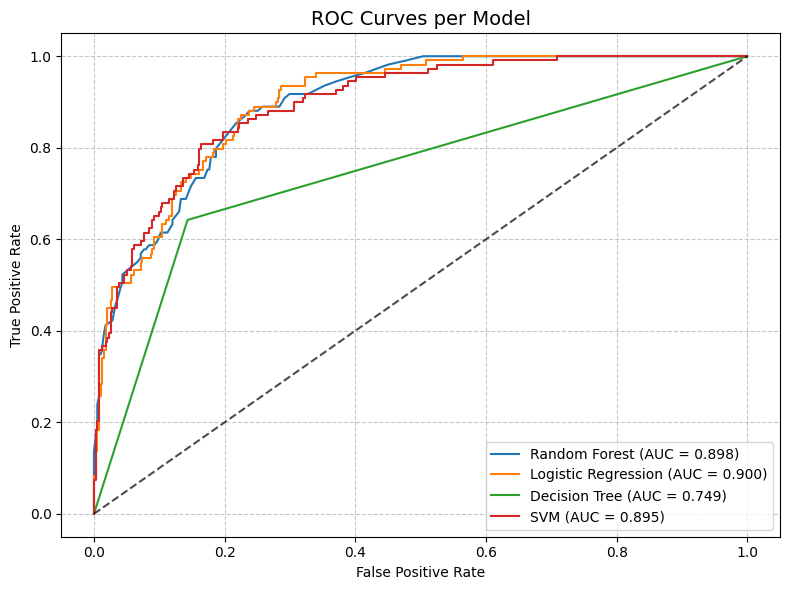

In [41]:
plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)

plt.title("ROC Curves per Model", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

We wil now perform a grid search on models using AUC on the validation set as the parameter to optimize

In [42]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Here we will define the parameters for the grid search

In [44]:
param_grids = {
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=123),
        "parameters": {
            "max_features": [None, "sqrt"],
            "min_samples_leaf": [1, 5],
            "min_samples_split": [2, 10],
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 10, 30],
            "class_weight": [None, "balanced"],
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(random_state=123),
        "parameters": {
            'C': [0.01, 0.1, 1],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],
            'max_iter': [2000, 5000],
            "class_weight": [None, 'balanced'],
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=123),
        "parameters": {
            "n_estimators": [50, 100],
            "criterion": ["gini"],
            "max_depth": [10, 30, None],
            "class_weight": [None, 'balanced'],
        }
    },
    "SVM": {
        "model": SVC(probability=True, random_state=123),
        "parameters": {
            'C': [0.1, 1, 10],
            'gamma': ['scale'],
            "class_weight": [None, 'balanced'],
            "kernel": ["linear"]
        }
    }
}

Now we can perform the grid search

In [45]:
#Stratified Fold Creation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=31)

# Dictionaries to save results
tuned_models = {}
best_params = {}

for name, config in param_grids.items():
    print(f"Hyperparameter tuning for {name}...")
    
    grid_search = GridSearchCV(
        estimator=config["model"],
        param_grid=config["parameters"],
        cv=stratified_kfold,
        scoring='roc_auc',
        return_train_score=True,
        verbose=0,
        n_jobs=-1
    )
    
    # Fit on Training Set
    grid_search.fit(X_train, y_train)
    
    # Best params and model
    best_params[name] = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    tuned_models[name] = best_model


print("Tuning Completed")


Hyperparameter tuning for Decision Tree...
Hyperparameter tuning for Logistic Regression...
Hyperparameter tuning for Random Forest...
Hyperparameter tuning for SVM...
Tuning Completed


Now let's take a look at what happens when we vary the classification threshold on the tuned models

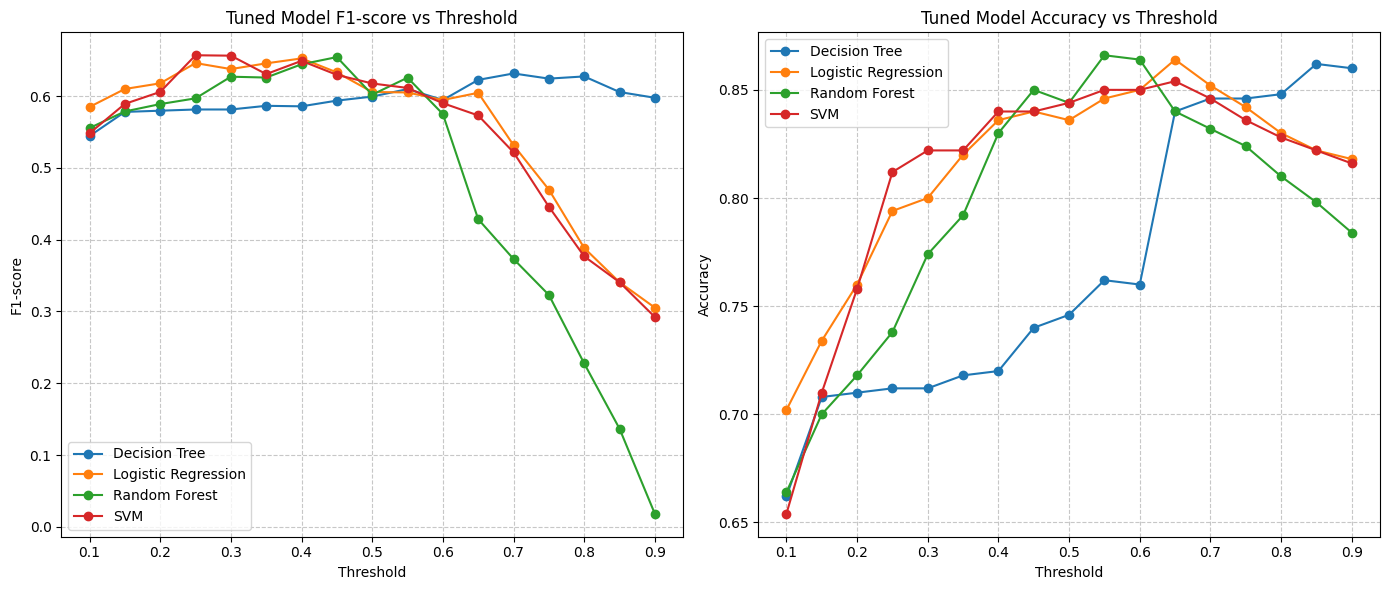

In [46]:
thresholds = np.arange(0.1, 0.91, 0.05)
results_f1 = pd.DataFrame(index=thresholds)
results_acc = pd.DataFrame(index=thresholds)
best_f1_dict = {}

for name, model in tuned_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    y_preds = [(y_proba >= thr).astype(int) for thr in thresholds]
    f1_scores = [f1_score(y_test, y_pred) for y_pred in y_preds]
    acc_scores = [accuracy_score(y_test, y_pred) for y_pred in y_preds]
    results_f1[name] = f1_scores
    results_acc[name] = acc_scores
    best_idx = np.argmax(f1_scores)
    best_f1_dict[name] = {"best_f1": f1_scores[best_idx], "threshold": thresholds[best_idx]}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for name in results_f1.columns:
    axes[0].plot(results_f1.index, results_f1[name], marker="o", label=name)
    axes[1].plot(results_acc.index, results_acc[name], marker="o", label=name)

axes[0].set(title="Tuned Model F1-score vs Threshold", xlabel="Threshold", ylabel="F1-score")
axes[1].set(title="Tuned Model Accuracy vs Threshold", xlabel="Threshold", ylabel="Accuracy")

for ax in axes:
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

We can see that the optimal threshold is not the default 0.5

We will now print the ROC curve for the tuned models

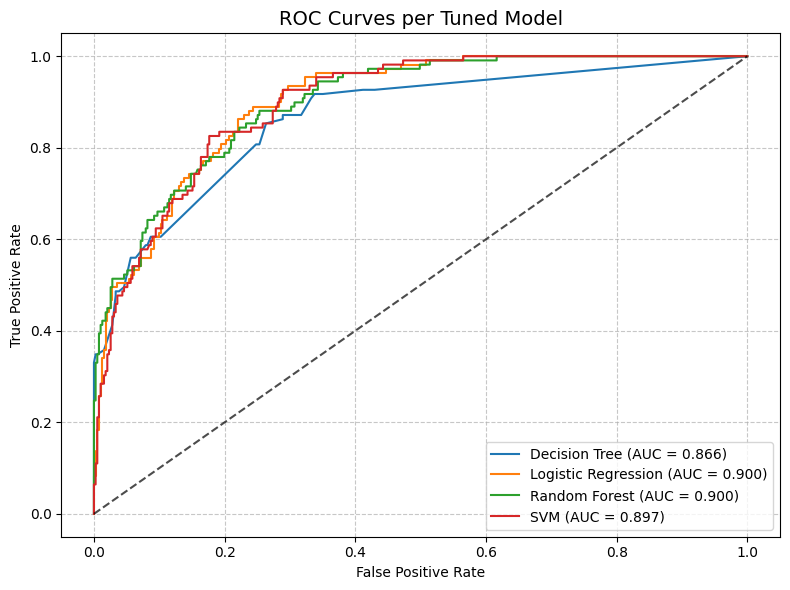

In [47]:
plt.figure(figsize=(8, 6))

for name, model in tuned_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)

plt.title("ROC Curves per Tuned Model", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

We can now compare the final results for each model

In [48]:

final_results = pd.DataFrame(columns=["Accuracy_initial", "Accuracy_tuned", "F1_initial",  "F1_tuned", "AUC_initial", "AUC_tuned", "Best F1", "Optimal Threshold"], index=models.keys())

for model_name in models.keys():
    pre_model=models[model_name]
    tuned_model = tuned_models[model_name]
    
    preds_pre = model.predict(X_test)
    y_proba_pre = model.predict_proba(X_test)[:, 1]

    preds_tuned = tuned_model.predict(X_test)
    y_proba_tuned = tuned_model.predict_proba(X_test)[:, 1]

    acc_pre = accuracy_score(y_test, preds_pre)
    f1_pre = f1_score(y_test, preds_pre)
    auc_pre = roc_auc_score(y_test, y_proba_pre)
    
    acc_tuned = accuracy_score(y_test, preds_tuned)
    f1_tuned = f1_score(y_test, preds_tuned)
    auc_tuned = roc_auc_score(y_test, y_proba_tuned)

    f1_best = best_f1_dict[model_name]["best_f1"]
    optimal_threshold = best_f1_dict[model_name]['threshold']
    
    final_results.loc[model_name] = [acc_pre,acc_tuned,f1_pre,f1_tuned, auc_pre,auc_tuned,f1_best,optimal_threshold]

Let's Look at results when sorted by Best F1

In [49]:
final_results.sort_values(by='Best F1',ascending=False)

,Accuracy_initial,Accuracy_tuned,F1_initial,F1_tuned,AUC_initial,AUC_tuned,Best F1,Optimal Threshold
SVM,0.842,0.842,0.614634,0.614634,0.897264,0.897264,0.656934,0.25
Random Forest,0.842,0.844,0.614634,0.602041,0.897264,0.900174,0.654378,0.45
Logistic Regression,0.842,0.836,0.614634,0.605769,0.897264,0.900185,0.652542,0.4
Decision Tree,0.842,0.746,0.614634,0.599369,0.897264,0.86587,0.631579,0.7


Let's take a look at the optimal parameters for each model

In [50]:
df_best_params = pd.DataFrame.from_dict(best_params,orient='index').fillna("/")

In [51]:
df_best_params

,class_weight,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,C,max_iter,penalty,solver,n_estimators,gamma,kernel
Decision Tree,balanced,entropy,10.0,/,5.0,2.0,/,/,/,/,/,/,/
Logistic Regression,/,/,/,/,/,/,1.0,2000.0,l2,liblinear,/,/,/
Random Forest,/,gini,10.0,/,/,/,/,/,/,/,100.0,/,/
SVM,/,/,/,/,/,/,0.1,/,/,/,/,scale,linear


<b> Feature Importance

Let's take a look at the most important features considered by every model in classification

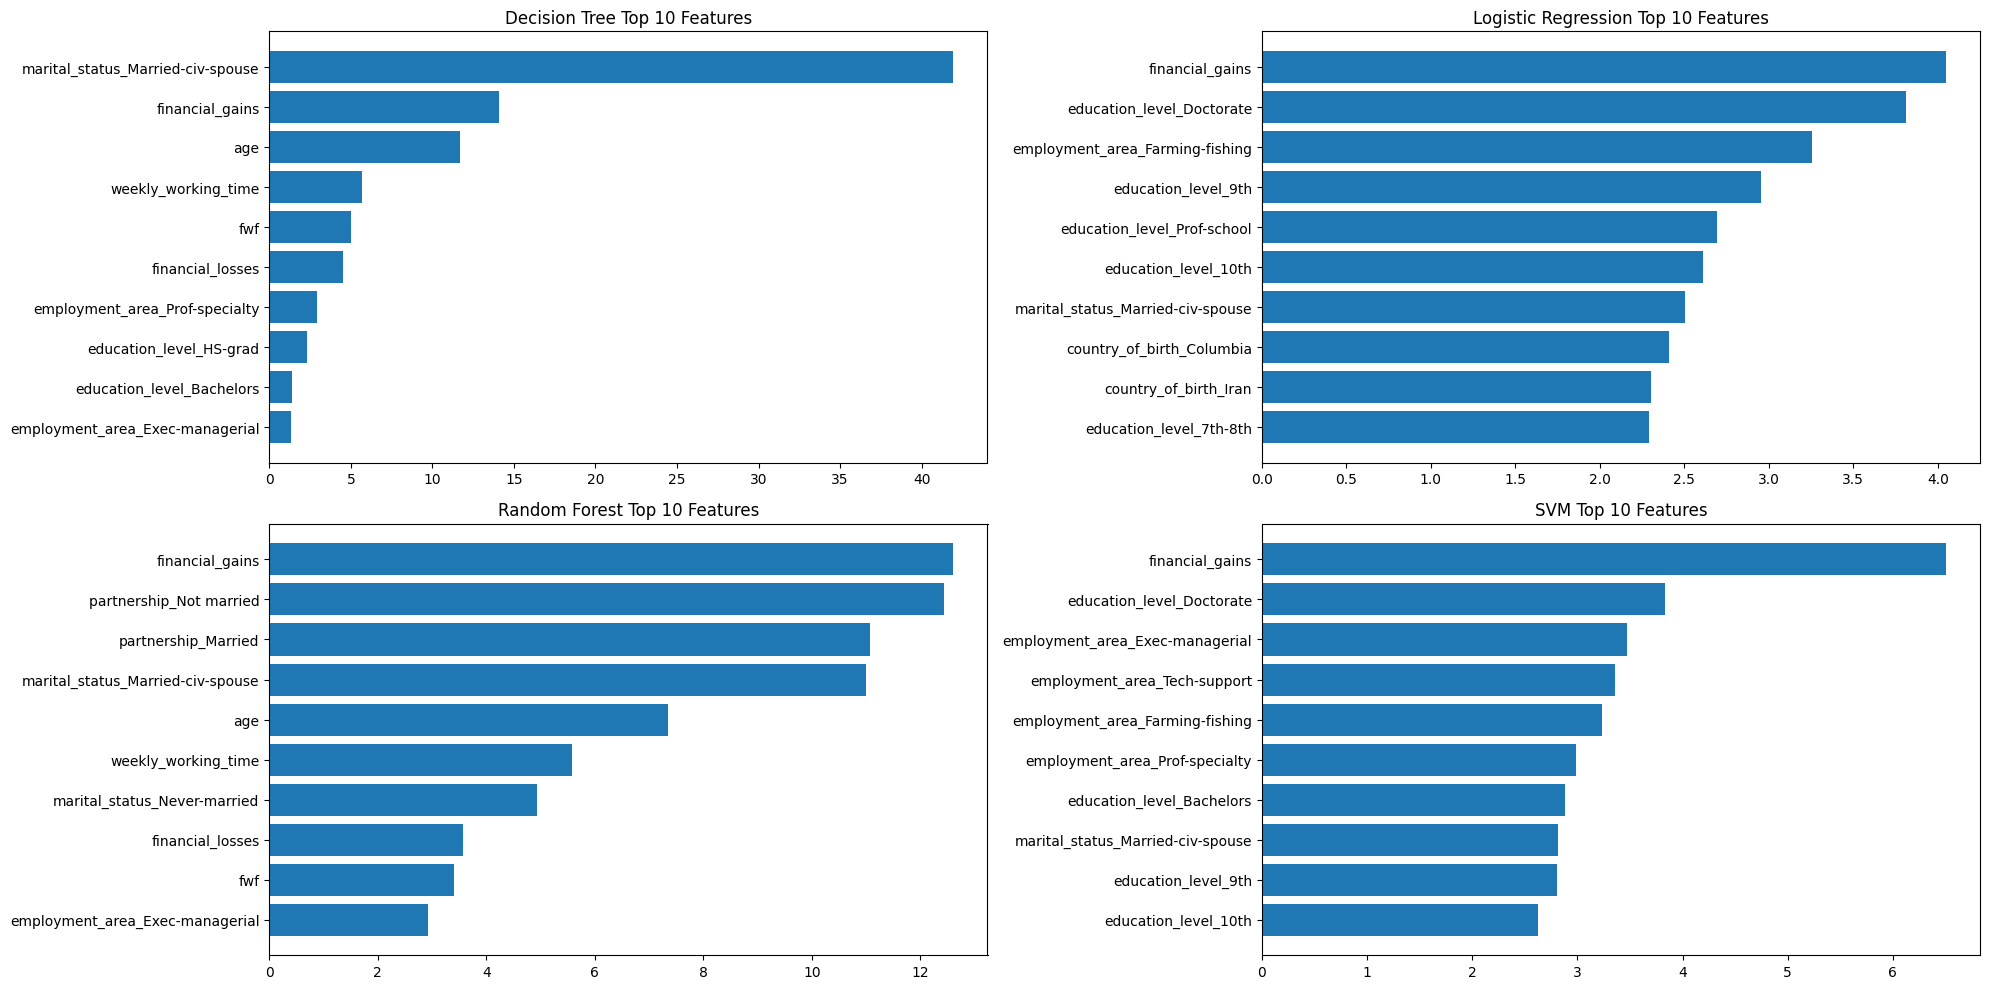

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

for ax, (name, model) in zip(axs, tuned_models.items()):
    if name in ["Decision Tree", "Random Forest"]:
        imp = model.feature_importances_
    else:
        imp = np.abs(model.coef_[0])
    imp = 100 * imp / imp.sum()
    df = pd.DataFrame({"Feature": X_train.columns, "Importance": imp}).sort_values("Importance", ascending=True).tail(10)
    ax.barh(df["Feature"], df["Importance"])
    ax.set_title(f"{name} Top 10 Features")

plt.tight_layout()
plt.show()

# Unknown Income prediction
It is now possible to train the tuned models on the whole data and predict the unknown incomes

In [1]:
from db_utils import preprocess_complete,data_path,columns

In [2]:
#Preprocess the unknown labels database
X_unk = preprocess_complete(data_path,names=columns,drop_unk=False)

In [4]:
#Preprocess the complete known labels database
X_complete,y_complete = preprocess_complete(data_path,names=columns,drop_unk=True)

In [ ]:
#Initialize predictions dictionary and predict unknown labels
preds_complete={}
for model_name in models.keys():
    model = models[model_name]
    model.fit(X_complete,y_complete)
    preds = model.predict(X_unk)
    preds_complete[model_name]=preds